# General imports

In [1]:
import numpy as np
import geopandas as gpd
import pprint

from geograypher.cameras.derived_cameras import MetashapeCameraSet
from geograypher.cameras.segmentor import SegmentorPhotogrammetryCameraSet
from geograypher.meshes import TexturedPhotogrammetryMesh
from geograypher.predictors.derived_segmentors import LookUpSegmentor
from geograypher.utils.prediction_metrics import compute_and_show_cf, compute_comprehensive_metrics
from geograypher.utils.indexing import find_argmax_nonzero_value
from geograypher.utils.visualization import show_segmentation_labels
from geograypher.constants import (
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_PREDICTED_LABELS_FOLDER,
    EXAMPLE_DTM_FILE,
    EXAMPLE_AGGREGATED_FACE_LABELS_FILE,
    EXAMPLE_PREDICTED_VECTOR_LABELS_FILE,
    EXAMPLE_IDS_TO_LABELS,
    EXAMPLE_LABEL_COLUMN_NAME,
    TEN_CLASS_VIS_KWARGS,
)

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


# Processing parameters

In [2]:
# Skip re-computing the aggregation and use a saved version
USE_CACHED_AGGREGATION = False
# Processing parameters
HEIGHT_ABOVE_GROUND_THRESH = 2  # Height above the DTM to consider not ground
MESH_DOWNSAMPLE_TARGET = 0.25  # Downsample the mesh to this fraction
AGGREGATE_IMAGE_SCALE = 0.25  # Aggregate images at this scale resolution
BUFFER_RADIUS_METER = 50  # Include cameras within this radius of labeled points
MESH_VIS_KWARGS = TEN_CLASS_VIS_KWARGS

LABEL_COLUMN_NAME = EXAMPLE_LABEL_COLUMN_NAME
IDS_TO_LABELS = EXAMPLE_IDS_TO_LABELS
CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
MESH_FILENAME = EXAMPLE_MESH_FILENAME
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
PREDICTED_IMAGE_LABELS_FOLDER = EXAMPLE_PREDICTED_LABELS_FOLDER
DTM_FILE = EXAMPLE_DTM_FILE
AGGREGATED_FACE_LABELS_FILE = EXAMPLE_AGGREGATED_FACE_LABELS_FILE
PREDICTED_VECTOR_LABELS_FILE = EXAMPLE_PREDICTED_VECTOR_LABELS_FILE

# Load the mesh

In [3]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=EXAMPLE_CAMERAS_FILENAME,
    IDs_to_labels=IDS_TO_LABELS,
)

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Extracting faces from mesh
Loading texture


# Load the camera set and subsample

In [4]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius=BUFFER_RADIUS_METER
)

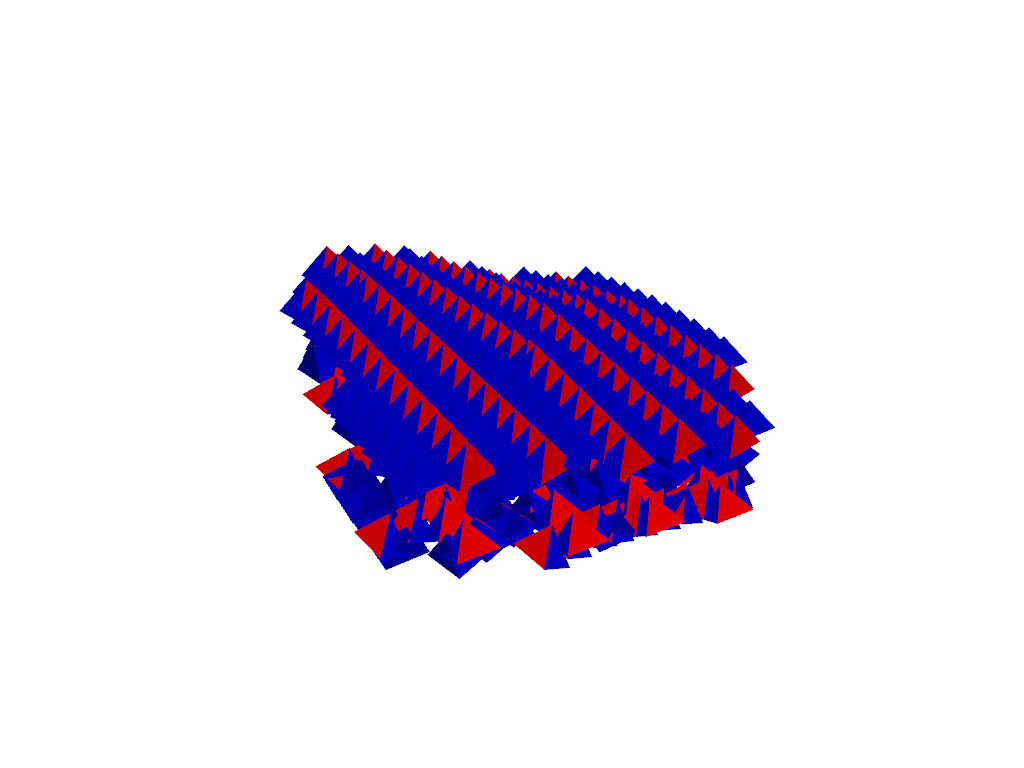

In [5]:
camera_set.vis()

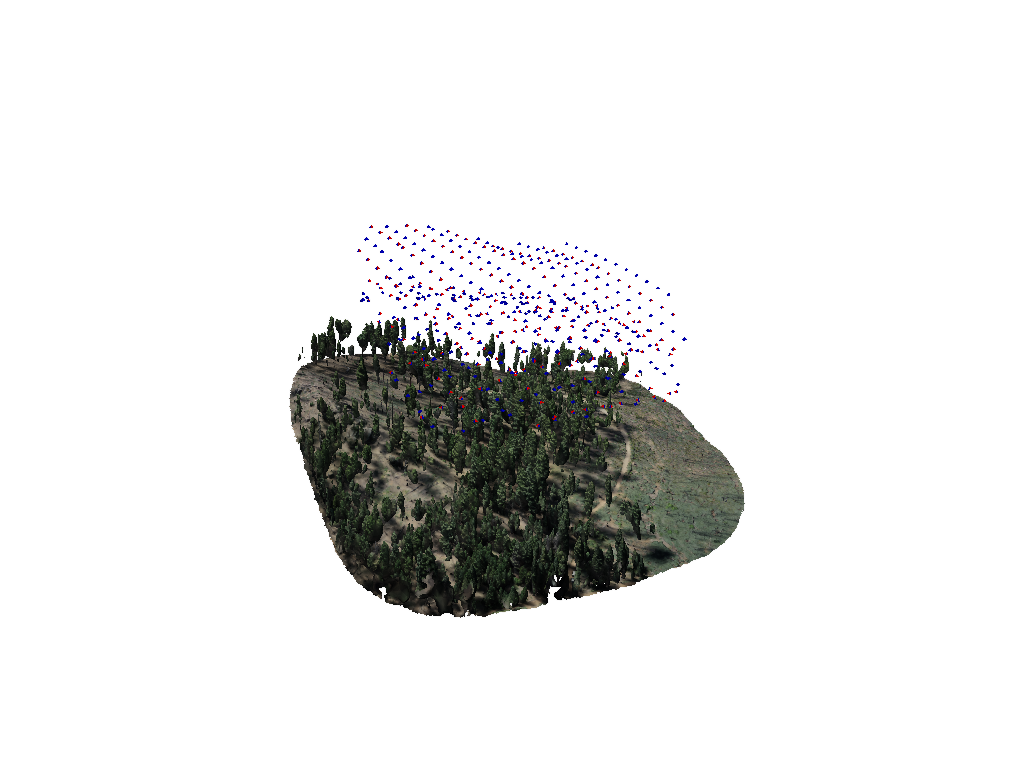

In [6]:
mesh.vis(camera_set=camera_set, force_xvfb=True)

# Show the per-image predictions

Showing segmentation labels: 0it [00:00, ?it/s]

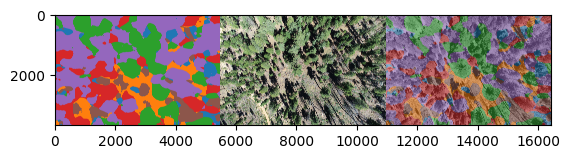

Showing segmentation labels: 1it [00:06,  6.02s/it]

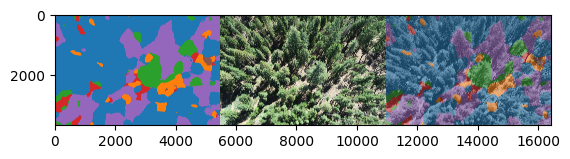

Showing segmentation labels: 2it [00:12,  6.31s/it]

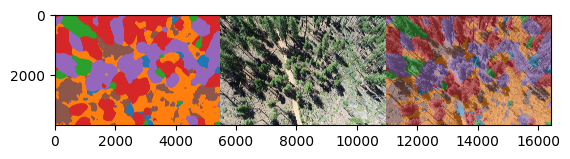

Showing segmentation labels: 3it [00:19,  6.52s/it]

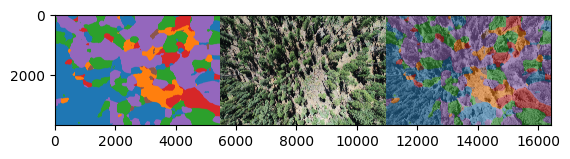

Showing segmentation labels: 4it [00:25,  6.50s/it]

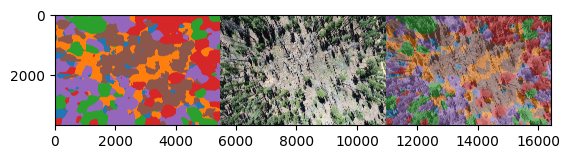

Showing segmentation labels: 5it [00:31,  6.36s/it]

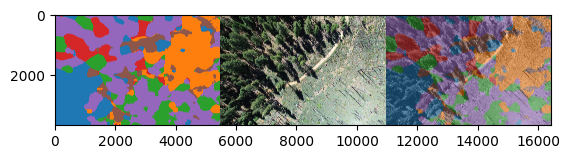

Showing segmentation labels: 6it [00:37,  6.23s/it]

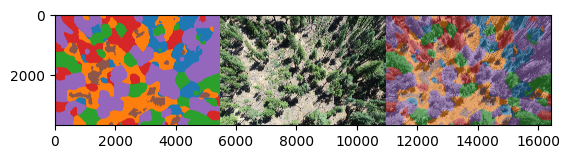

Showing segmentation labels: 7it [00:43,  6.11s/it]

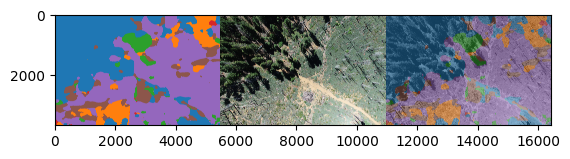

Showing segmentation labels: 8it [00:50,  6.34s/it]

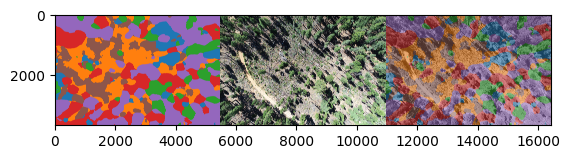

Showing segmentation labels: 9it [00:56,  6.31s/it]

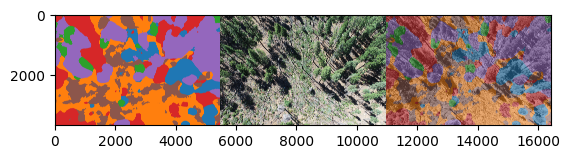

Showing segmentation labels: 10it [01:02,  6.29s/it]


In [7]:
show_segmentation_labels(label_folder=PREDICTED_IMAGE_LABELS_FOLDER, image_folder=IMAGE_FOLDER, IDs_to_labels=IDS_TO_LABELS)

In [8]:
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=len(mesh.get_label_names()),
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    camera_set, segmentor=segmentor
)

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


In [9]:
if USE_CACHED_AGGREGATION:
    aggregated_face_labels = np.load(AGGREGATED_FACE_LABELS_FILE)
else:
    aggregated_face_labels, _ = mesh.aggregate_projected_images(
        segmentor_camera_set,
        aggregate_img_scale=AGGREGATE_IMAGE_SCALE,
    )
    np.save(AGGREGATED_FACE_LABELS_FILE, aggregated_face_labels)

Aggregating projected viewpoints: 100%|██████████| 473/473 [14:02<00:00,  1.78s/it]


In [10]:
predicted_face_classes = find_argmax_nonzero_value(aggregated_face_labels, keepdims=True)
predicted_face_classes = mesh.label_ground_class(
    labels=predicted_face_classes,
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    ground_ID=np.nan,
    set_mesh_texture=False,
)

Sampling values from raster /ofo-share/repos-david/geograypher/data/chips_tree_species/inputs/chips_DTM.tif: 100%|██████████| 633496/633496 [00:26<00:00, 24260.27it/s]


# Show the projected and aggregated face predictions

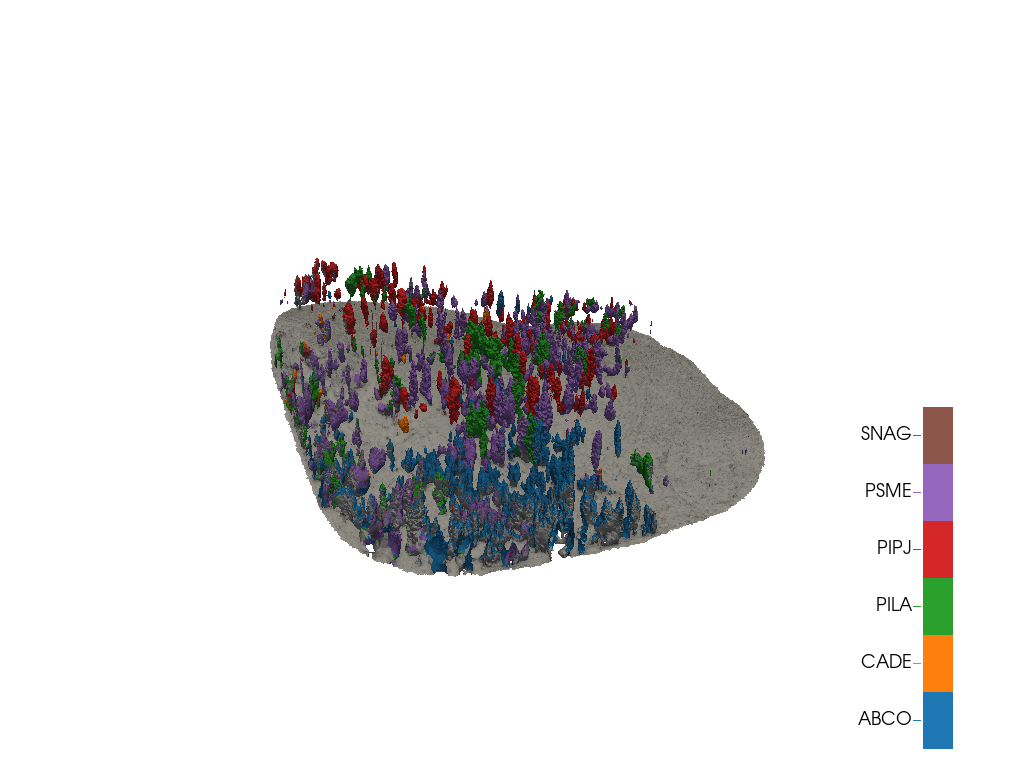

In [11]:
mesh.vis(vis_scalars=predicted_face_classes)

# Use the mesh predictions to generate per-polygon labels

In [12]:
# Load the data
polygons = gpd.read_file(LABELS_FILENAME)
# Assign a label to each polygon using the mesh faces that overlap with it
predicted_polygon_labels = mesh.label_polygons(
    face_labels=predicted_face_classes,
    polygons=polygons
)

Computing faces in working CRS


Converting faces to polygons: 100%|██████████| 704465/704465 [00:11<00:00, 63894.24it/s]

Creating dataframe of faces



Computing ratio of 3d to 2d area: 100%|██████████| 704465/704465 [00:06<00:00, 110395.92it/s]


Starting to subset to ROI


/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Subset to ROI in 1.0676565170288086 seconds
Starting `overlay`
Overlay time with gpd.sjoin: 0.30852341651916504


# Compute prediction accuracy

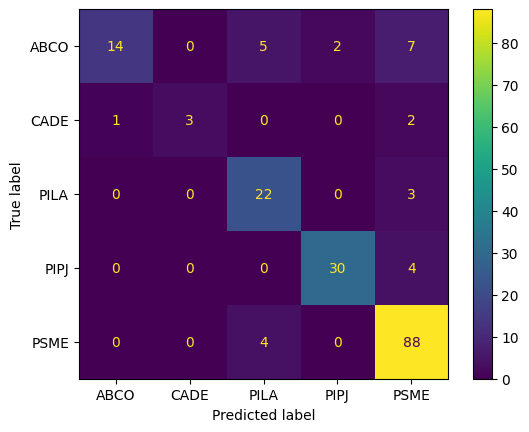

Accuracy was 0.8486486486486486
Comprehensive metrics:
{ 'accuracy': 0.8486486486486486,
  'class_averaged_precision': 0.8853329197684037,
  'class_averaged_recall': 0.7437749360613811,
  'per_class': { 'ABCO': { 'acc': 0.918918918918919,
                           'num_pred': 15,
                           'num_true': 28,
                           'precision': 0.9333333333333333,
                           'recall': 0.5},
                 'CADE': { 'acc': 0.9837837837837838,
                           'num_pred': 3,
                           'num_true': 6,
                           'precision': 1.0,
                           'recall': 0.5},
                 'PILA': { 'acc': 0.9351351351351351,
                           'num_pred': 31,
                           'num_true': 25,
                           'precision': 0.7096774193548387,
                           'recall': 0.88},
                 'PIPJ': { 'acc': 0.9675675675675676,
                           'num_pred': 32,
     

In [13]:
# Extract the ground truth classes
ground_truth_labeling = polygons[LABEL_COLUMN_NAME]
# Get all the possible classes, in case you wanted to compare across sites where only
# a subset of all classes were present at one
# Drop the ground class because no polygons are labeled that
all_classes = list(IDS_TO_LABELS.values())[:-1]
# Compute the confusion matrix
cf_matrix, _, accuracy = compute_and_show_cf(
    pred_labels=predicted_polygon_labels,
    gt_labels=ground_truth_labeling,
    labels=all_classes
)
print(f"Accuracy was {accuracy}")
# Compute more detailed metrics from the confusion matrix
comprehensive_metrics = compute_comprehensive_metrics(
    cf_matrix=cf_matrix,
    class_names=all_classes
)
# Format and print the dict
pp = pprint.PrettyPrinter(indent=2)
print("Comprehensive metrics:")
print(pp.pprint(comprehensive_metrics))